For this project you will need Columbia Object Image Library (COIL-100) Dataset

The image set is the COIL-100 dataset, which contains 7200 images of 100 objects
Original data source and banner image: 
http://www1.cs.columbia.edu/CAVE/software/softlib/coil-100.php \
This dataset is intended for non-commercial research purposes only. When using this dataset, please cite: \
"Columbia Object Image Library (COIL-100)," \
S. A. Nene, S. K. Nayar and H. Murase, \
Technical Report CUCS-006-96, February 1996.

Download and store the image files in the folder `data/coil-100/`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.interpolate import RBFInterpolator

In [2]:
# function to display an image without axii, works with numpy arrays and PIL images
def imdisplay(im):
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    plt.show()
    plt.close()

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128 at 0x29656F010>
Image shape:  (128, 128)
Image array shape:  (128, 128, 3)


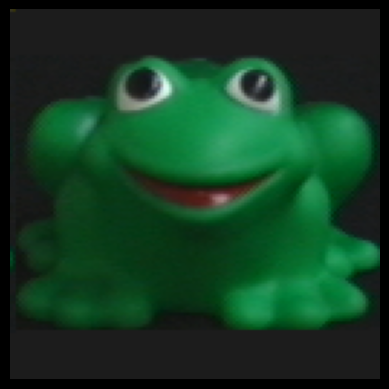

Image array shape:  (128, 128)


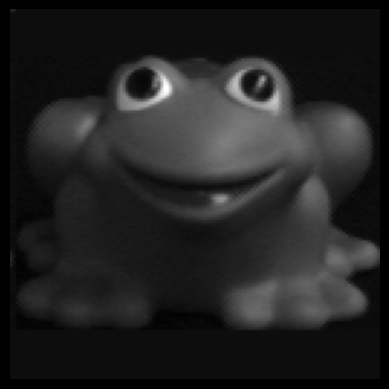

In [3]:
# Open an image file and display it
img_folder = "data/coil-100/"
with Image.open(img_folder + 'obj28__275.png') as img:
    print(img)
    shape = img.size
    print("Image shape: ", shape)
    img_ar = np.asarray(img)
    print("Image array shape: ", img_ar.shape)
    imdisplay(img)
    # convert to grayscale and display the image
    img = img.convert("L")
    img_ar = np.asarray(img)
    print("Image array shape: ", img_ar.shape)
    imdisplay(img)

## Part I: Image discrimination 

Number of images:  7200
X shape:  (7200, 16384)
y shape:  (7200,)
Frog shape:  (72, 16384)


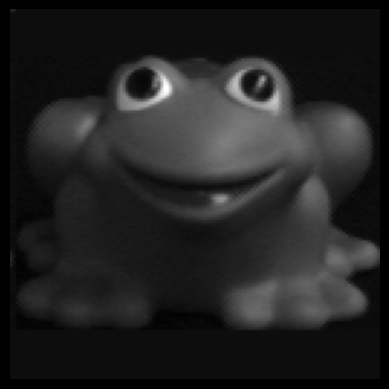

In [4]:
# Read all the images from the folder "coil-100"
# convert to grey scale, flatten and store in a numpy array as image vectors
# store the labels in a list
X = []
y = []
for obj in range(1, 101):
    for angle in range(0, 360, 5):
        file = "obj" + str(obj) + "__" + str(angle) + ".png"
        with Image.open(img_folder + file) as img:
            img = img.convert("L")
            img_ar = np.asarray(img)
            X.append(img_ar.flatten())
            y.append(obj)
print("Number of images: ", len(X))
X_original = np.array(X)
y_original = np.array(y)
print("X shape: ", X_original.shape)
print("y shape: ", y_original.shape)
# display obj28 (frog) as array and image
frogs_index = np.where(y_original == 28)
frogs = X_original[frogs_index]
print("Frog shape: ", frogs.shape)
imdisplay(frogs[55].reshape(shape))
N = X_original.shape[0] # Total number of images

In [5]:
# Normalization and centering
# Normalize each image vector to remove brightness variations
# (Frobenius norm: vector length = sqrt(sum of squares of coordinates))
X_original = X_original/np.linalg.norm(X_original, axis=1)[:, None]
# Check that the sum of all elements in each image vector is 1 (Total N vectors)
norm_sum = np.sum(np.linalg.norm(X_original, axis=1)[:, None])
print("Sum of all lengths of image vectors: ", norm_sum)
print(norm_sum == N)
# Since centering is done by subtracting the mean of all images, we need to 
# split the images into training and test sets before mean subtraction to avoid data leaking.
# Later we need to subtract this mean from the test set as well.
# Split the data into training and test sets such that for each object, 80% of the images 
# are in the training set and 20% in the test set. 
# (I keep the train sets notation as X and y)
for obj in range(1, 101):
    obj_indices = np.where(y_original == obj)[0]
    if obj == 1:
        X, X_test, y, y_test = train_test_split(X_original[obj_indices], y_original[obj_indices], test_size=0.2) 
    else:
        X_obj, X_obj_test, y_obj, y_obj_test = train_test_split(X_original[obj_indices], y_original[obj_indices], test_size=0.2)
        X = np.vstack((X, X_obj))
        y = np.hstack((y, y_obj))
        X_test = np.vstack((X_test, X_obj_test))
        y_test = np.hstack((y_test, y_obj_test))
print("Shapes of train and test sets:")
print("X: ", X.shape)
print("X_test: ", X_test.shape)
print("y: ", y.shape)
print("y_test: ", y_test.shape)
N_train = X.shape[0] # number of training images/vectors/samples
# Center the data by subtracting the mean of all the images in the training set
X_mean = np.mean(X, axis=0)
X = X - X_mean
# Shuffle the sets since they are ordered by object number
shuffle = np.random.permutation(N_train)
X = X[shuffle]
y = y[shuffle]
shuffle = np.random.permutation(N - N_train)
X_test = X_test[shuffle]
y_test = y_test[shuffle]
print("Training set y: ", y)

Sum of all lengths of image vectors:  7200.0
True
Shapes of train and test sets:
X:  (5700, 16384)
X_test:  (1500, 16384)
y:  (5700,)
y_test:  (1500,)
Training set y:  [ 3 86 94 ... 38 71 90]


In [6]:
# Perform SVD on the data
# X = U*S*Vt, where U and Vt are orthogonal matrices and S is a diagonal matrix
# containing the singular values of X in decreasing order, the columns of U are the left singular vectors
# and the rows of Vt are the right singular vectors
print("X shape: ", X.shape)
U, S, Vt = np.linalg.svd(X, full_matrices=False)
print("U shape: ", U.shape)
print("S shape: ", S.shape)
print("Vt shape: ", Vt.shape)
# This step takes a bit of time, on my machine ~2-3 mins for 80% of the images

X shape:  (5700, 16384)
U shape:  (5700, 5700)
S shape:  (5700,)
Vt shape:  (5700, 16384)


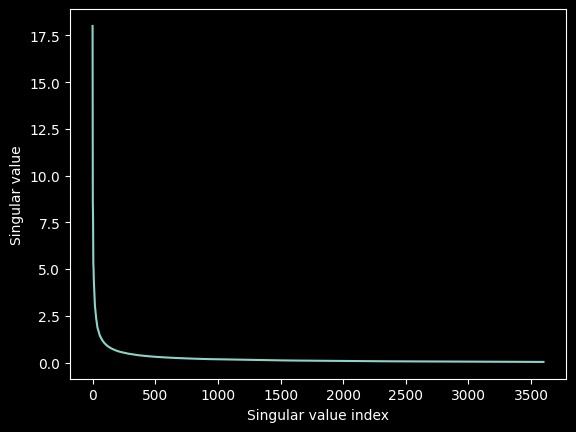

In [7]:
# There are N_train singular values
# Display first M
M = 3600
plt.plot(S[:M])
plt.xlabel("Singular value index")
plt.ylabel("Singular value")
plt.show()

Approximation shape:  (5700, 16384)
Approximation degree T (smaller is better):  0.44573491031373125
k:  285 T:  0.2477276206697275


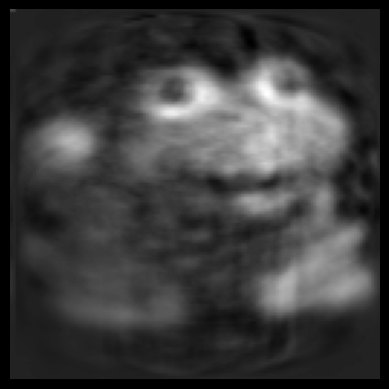

k:  570 T:  0.18075882996910542


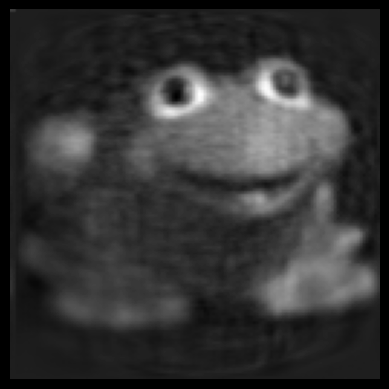

k:  1140 T:  0.11759079918489652


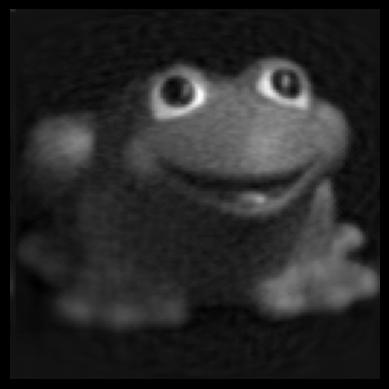

k:  5700 T:  1.2269171188685397e-14


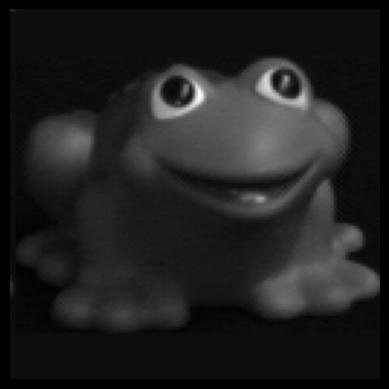

In [8]:
# Choose the number of principal components to keep, i.e. reduced order, cut-off,
# by setting a threshold for the singular singular values at k, ideally this threshold should be
# chosen somewhere after the signigicant drop in the singular values.
# (experiment with 5, 10, 15, 20 percent of the total number of singular values 
# if you are not sure, having anything below 30% and getting positive results is already a good approximation)
k = 45
# Compute the approximation of X by the first k principal components
Uk, Sk, Vtk = U[:, :k], S[:k], Vt[:k, :]
X_trunc = Uk @ np.diag(Sk) @ Vtk
print("Approximation shape: ", X_trunc.shape)
# calculate the approximation error by the Frobenius norm
T = np.linalg.norm(X - X_trunc, ord='fro')/np.linalg.norm(X, ord='fro')
print("Approximation degree T (smaller is better): ", T)
# Display approximation for different cutoffs
frogs_index = np.where(y == 28)
for percent in [.05, .1, .2, 1]:
    k1 = int(percent*N_train)
    Uk1, Sk1, Vtk1 = U[:, :k1], S[:k1], Vt[:k1, :]
    X_trunc1 = Uk1 @ np.diag(Sk1) @ Vtk1
    T1 = np.linalg.norm(X - X_trunc1, ord='fro')/np.linalg.norm(X, ord='fro')
    print("k: ", k1, "T: ", T1)
    imdisplay((X_trunc1[frogs_index][1]+X_mean).reshape(shape))

In [9]:
# Constructing manifolds for each object 
# By projecting each image of an object P onto truncated eigen space we get a set of points
# These points are fitted to a manifold correspoding to that object P using RBF interpolation
# First we construct classification vector for all objects

# Construct one-hot encoding for each object
Y = np.zeros((X.shape[0], 100))
for i in range(100):
    Y[y == i+1, i] = 1
print ("Y shape: ", Y.shape)
# Project each image onto the truncated eigen space
X_proj = X @ Vtk.T
print("Projected shape: ", X_proj.shape)
print(len(Y))
print(len(X_proj))
# Fit the projected points to a manifold using RBF interpolation
# Parameters for RBF interpolation should be chosen through cross-validation
rbf_interpolation = RBFInterpolator(X_proj, Y, kernel='gaussian', epsilon=2)

Y shape:  (5700, 100)
Projected shape:  (5700, 45)
5700
5700


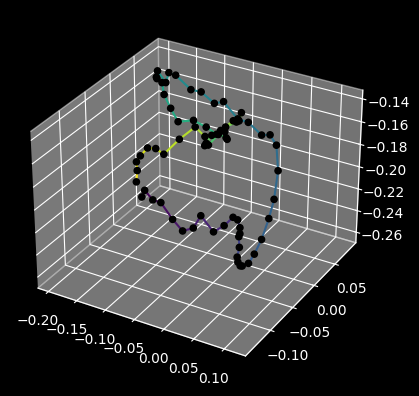

In [10]:
# Display image poses for the first 3 principal vectors. 
# Reading from files to keep the order of the poses
# (I could have used the original data, but I wanted to keep the order of the poses)
obj = 'obj74'
poses = []
for i in range(0, 360, 5):
    with Image.open(img_folder + f'{obj}__{i}.png') as img:
        img = img.convert("L")
        img_ar = np.asarray(img)
        poses.append(img_ar.flatten())
poses = np.array(poses)
poses = poses/np.linalg.norm(poses, axis=1)[:, None]
poses = poses - X_mean
poses_proj = poses @ Vtk.T
# display the points in the truncated eigen space keeping the first 3 principal components
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(poses_proj[:, 0], poses_proj[:, 1], poses_proj[:, 2], alpha = 1., color='black')
# also connect the points with lines changing the color according to a cmap
cycle = plt.cm.viridis(np.linspace(0, 1, poses_proj.shape[0]))
for i in range(poses_proj.shape[0]-1):
    ax.plot(poses_proj[i:i+2, 0], poses_proj[i:i+2, 1], poses_proj[i:i+2, 2], color=cycle[i])
plt.show()
plt.close()

In [11]:
# Some more processing is needed to get the test set ready
# Center the test set by subtracting the mean of the training set
# (not the mean of the test set, since in reality we can have a single sample for classification and 
# substracting a mean out of 1 sample makes no sense.
# Hence the mean of the training set is a parameter of our model)
X_test = X_test - X_mean
# Project the test set onto the truncated eigen space
X_test_proj = X_test @ Vtk.T
# Construct collapsed one-hot encoding for the test set
y_test_class = np.zeros_like(y_test, dtype=int)
for i in range(100):
    y_test_class[y_test == i+1] = i + 1
print("y_test_class: ", y_test_class)

y_test_class:  [53 66 48 ... 64  4 88]


In [12]:
# Test the classifier on test data
class_pred = rbf_interpolation(X_test_proj)
print("Test class shape: ", class_pred.shape)
class_pred = np.argmax(class_pred, axis=1) + 1
accuracy = np.sum(class_pred == y_test_class)/len(y_test_class)
print("Accuracy: ", accuracy)

Test class shape:  (1500, 100)
Accuracy:  0.9953333333333333


Predicted classes: [53 66 48 ... 64  4 88]
True test classes [53 66 48 ... 64  4 88]
[21 67 21 27 68 67 21]
[97 84 97 76 92 84 97]
True class:  21 Predicted class:  97


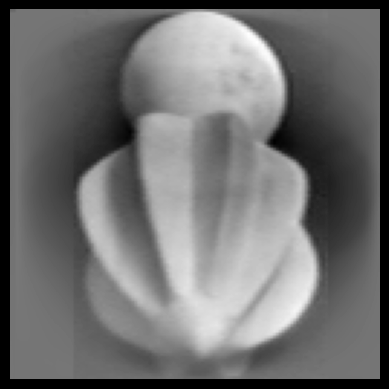

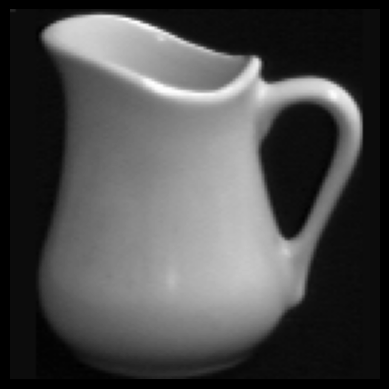

True class:  67 Predicted class:  84


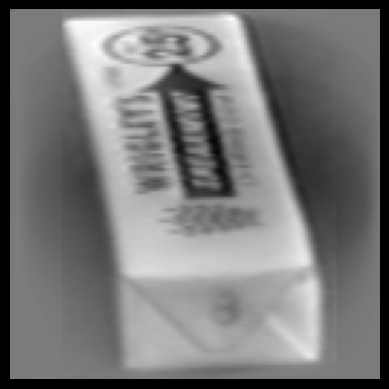

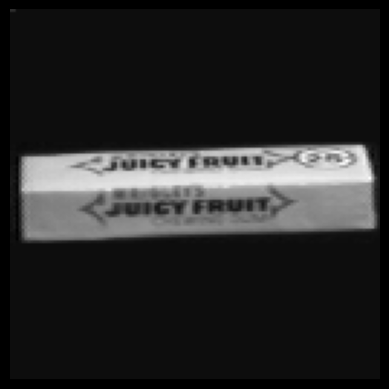

True class:  21 Predicted class:  97


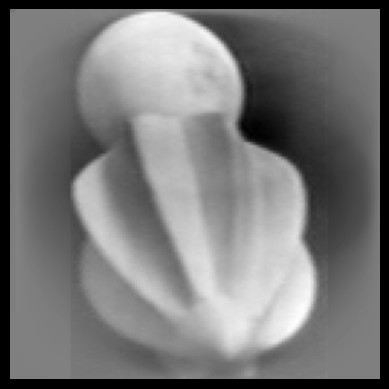

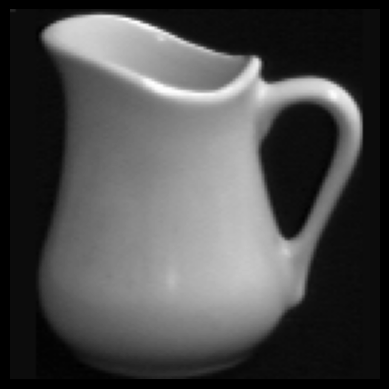

True class:  27 Predicted class:  76


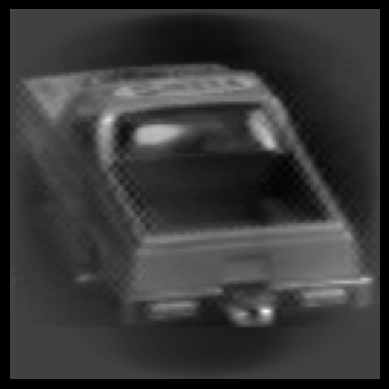

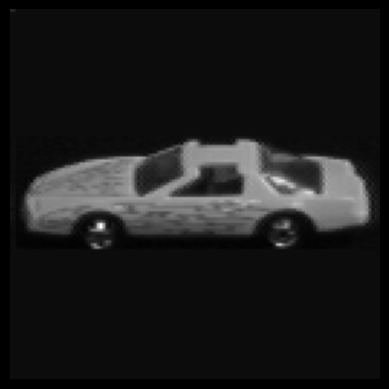

True class:  68 Predicted class:  92


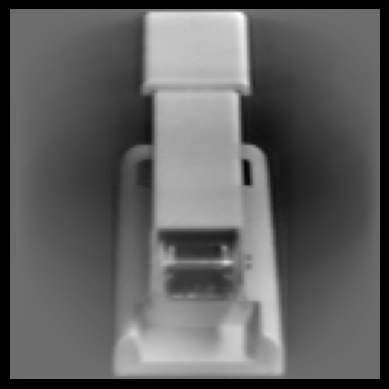

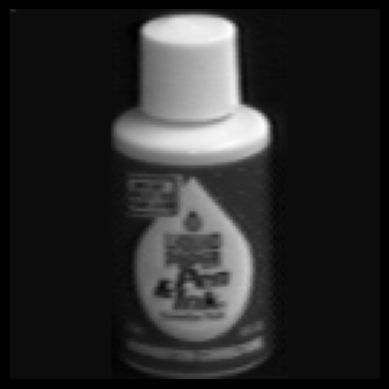

True class:  67 Predicted class:  84


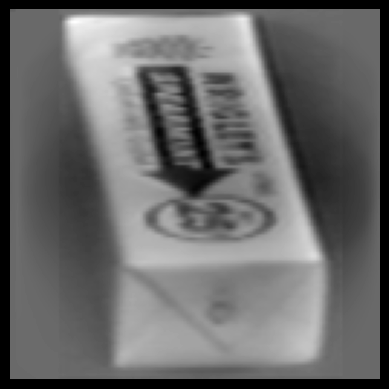

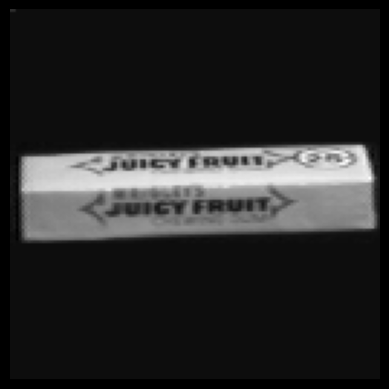

True class:  21 Predicted class:  97


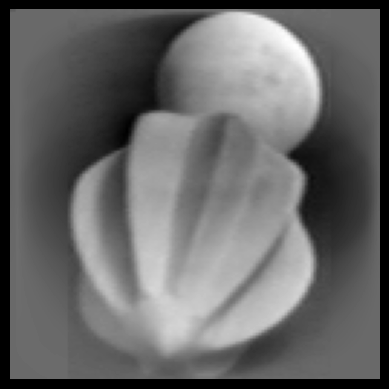

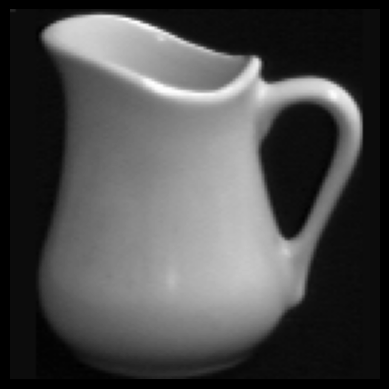

In [13]:
print("Predicted classes:", class_pred)
print("True test classes", y_test_class)
print(y_test_class[y_test_class != class_pred])
print(class_pred[y_test_class != class_pred])
# Display the misclassified images along with their true and predicted classes
misclass_index = np.where(y_test_class != class_pred)
misclass_images = X_test[misclass_index]
misclass_true = y_test_class[misclass_index]
misclass_pred = class_pred[misclass_index]

for i in range(len(misclass_images)):
    print("True class: ", misclass_true[i], "Predicted class: ", misclass_pred[i])
    imdisplay(misclass_images[i].reshape(shape))
    with Image.open(img_folder + f'obj{misclass_pred[i]}__0.png') as img:
        img = img.convert("L")
        imdisplay(img)

### TODOs:
- [+] Object discrimination
- [+] Train/split for each object class
- [-] Cross-validation
- [-] k truncation tuning
- [-] RBF epsilon tuning
- [-] Pose estimation


### References
1. Murase, H., Nayar, S.K. Visual learning and recognition of 3-d objects from appearance. Int J Comput Vision 14, 5–24 (1995). https://doi.org/10.1007/BF01421486



In [15]:
a = np.array([[0, 1, 2], [3, 4, 5]])
print(a[0,1])

1
